In [1]:
import numpy as np 
import pandas as pd 
import h5py 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from ipywidgets import interact, interact_manual,fixed
from ipywidgets import widgets # Widget definitions
from IPython.display import display, HTML, Math, Latex # Used to display widgets in the notebook

%matplotlib inline 

In [63]:
figname='lt'
h5file=h5py.File("/Users/pablo/Development/PostNewton3BP/exe/Fig3_"+figname+"/output.h5")

In [64]:
def get_dynamic_variable(h5file, dataset):
    Np=h5file['0'][dataset].attrs['np'][0]
    Dim=h5file['0'][dataset].attrs['dim'][0]
    coord=['x','y','z']    
    cols=['t']
    for p in np.arange(Np):
        for i in np.arange(Dim):
            cols.append(coord[i]+str(p+1))
    df=pd.DataFrame(h5file['0'][dataset][:],columns=cols)
    if Dim ==2:
        for p in np.arange(Np):
            df['z'+str(p+1)]=0
        return df.reindex_axis(sorted(df.columns),axis=1)
    return df

df_x=get_dynamic_variable(h5file, "position").set_index('t')
df_p=get_dynamic_variable(h5file, "momentum").set_index('t')

df_dxdt=get_dynamic_variable(h5file, "dxdt").set_index('t')
df_dpdt=get_dynamic_variable(h5file, "dpdt").set_index('t')

df_ddxdt2=get_dynamic_variable(h5file, "ddxdt2").set_index('t')
df_ddpdt2=get_dynamic_variable(h5file, "ddpdt2").set_index('t')

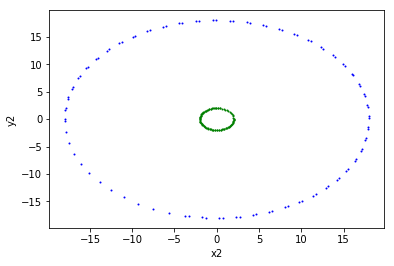

In [65]:
ax=df_x.plot.scatter(x='x1',y='y1',s=1,c='g')
ax=df_x.plot.scatter(x='x2',y='y2',s=1,c='b',ax=ax)


In [94]:
m=h5file['0/position'].attrs['mass']
num_part=h5file['0/position'].attrs['np'][0]
dim=h5file['0/position'].attrs['dim'][0]

p_idx=np.arange(num_part)
d_idx=np.arange(dim)

def phi(xx,yy,zz,x,m,mR2,P2):
    X=np.array([xx,yy,zz])
    R1=X-x
    mR1=np.linalg.norm(R1,axis=1)
    phi2= 4*np.sum([m[a]/mR1[a] for a in p_idx ])
    phi4= 2*np.sum([P2[a]/(m[a]*mR1[a]) for a in p_idx])-2*np.sum([np.sum([0 if a==b else m[a]*m[b]/(mR1[a]*mR2[a,b]) for a in p_idx ]) for b in p_idx])

    return phi2+phi4


def HTT_ret(ra,ra_ret,uv,nv,i,j):
    un2=uv.dot(nv)**2
    u2=uv.dot(uv)
    result=0
    if(i==0):
        result+=u2-5*un2
    result+=2*uv[i]*uv[j]+n[i]*n[j]*(3*un2-5*u2)+12*uv.dot(nv)*(uv[i]*nv[j]+uv[j]*nv[i])    
    return -0.25*result/ra

def lin_interpolation(x0,x,x1,y0,y1):
    return (y1-y0)*(x-x0)/(x1-x0)+y0


def hTT(xx,yy,zz,x,p,m,mR2,n2,P2,i,j,df_x,df_p,t):
    dij=1 if i==j else 0
    X=np.array([xx,yy,zz])
    R1=X-x
    mR1=np.linalg.norm(R1,axis=1)
    n1=np.array([R1[a]/mR1[a] for a in p_idx])
    s1=0
    t_ret=t-mR1
    if np.all(t_ret>0):
        t_min=[df_x.index[df_x.index<t_ret[a]][-1] for a in p_idx]
        t_max=[df_x.index[df_x.index>=t_ret[a]][0] for a in p_idx]
        
        x_ret=np.array([ lin_interpolation(tm,t_ret[a],tM,df_x.loc[tm].values.reshape((3,num_part)).T[a],df_x.loc[tM].values.reshape((3,num_part)).T[a]) for tm,tM,a in zip(t_min,t_max,p_idx)])
        p_ret=np.array([ lin_interpolation(tm,t_ret[a],tM,df_p.loc[tm].values.reshape((3,num_part)).T[a],df_p.loc[tM].values.reshape((3,num_part)).T[a]) for tm,tM,a in zip(t_min,t_max,p_idx)])

        print(x_ret)
        
    hret=0
    for a in p_idx:
        s1+=dij*(P2[a]-5*n1[a].dot(p[a]))+2*p[a,i]*p[a,j] + n1[a,i]*n1[a,j]*(3*(n1[a].dot(p[a]))**2 -5*P2[a])+12*(n1[a].dot(p[a])*(n1[a,i]*p[a,j]+n1[a,j]*p[a,i]))
        s1/=4*(m[a]*mR1[a])
        
#        if np.all(t_ret>0):
            #hret+=HTT_ret(mR1[a],mR1_ret[a],p[a]/sp.sqrt(m[a]),n1[a],i,j)
        
        s2=0
        for b in p_idx:
            if a==b:
                continue
            s_ab=mR1[a]+mR1[b]+mR2[a,b]
            s2+= -32*n2[a,b,i]*n2[a,b,j]*(1.0/mR2[a,b]+1.0/s_ab)/s_ab+2*n1[a,i]*n1[a,j]*((mR1[a]+mR1[b])/mR2[a,b]**3+12/s_ab**2)
            s2+= 32*(n1[a,i]*n2[a,b,j]+n1[a,j]*n2[a,b,i])*(2.0/s_ab**2-1.0/mR2[a,b]**2) + n1[a,i]*n1[a,j]*(5.0/(mR2[a,b]*mR1[a])-(mR1[b]**2/mR1[a]+3*mR1[a])/mR2[a,b]**3 - 8*(1.0/mR1[a]+1.0/s_ab)/s_ab)
            s2+= dij*(5*mR1[a]*(mR1[a]/mR1[b]-1)/mR2[a,b]**3 - 17.0/(mR2[a,b]*mR1[a]) + 4.0/(mR1[a]*mR1[b]) + 8*(1.0/mR1[a]+4.0/mR2[a,b])/s_ab )
            s2*=m[a]*m[b]*0.125
    return s1+s2

nx=64
ny=64
nz=4

L=[200,200,1]
C=[0,0,0]

xx=np.linspace(start=C[0]-L[0]/2.,stop=C[0]+L[0]/2.,num=nx)
yy=np.linspace(start=C[1]-L[1]/2.,stop=C[1]+L[1]/2.,num=ny)
zz=np.linspace(start=C[2]-L[2]/2.,stop=C[2]+L[2]/2.,num=nz)
X,Y,Z =np.meshgrid(xx,yy,zz)


t_list=df_x.index[1:]

In [95]:
xc=100
yc=0
zc=0

dump_list=list()
for t in t_list:
    x=df_x.loc[t].values.reshape((3,num_part)).T
    p=df_p.loc[t].values.reshape((3,num_part)).T
        
    P2=np.array([p[a].dot(p[a]) for a in p_idx])
    
    R2=np.array([[x[b]-x[a] for a in p_idx] for b in p_idx])
    mR2=np.linalg.norm(R2,axis=2)
    
    n2=np.array([[ np.zeros_like(R2[a,b]) if a==b else R2[a,b]/mR2[a,b] for a in p_idx] for b in p_idx])
    
    Phi=phi(xc,yc,zc,x,m,mR2,P2)
    Htt_11=hTT(xc,yc,zc,x,p,m,mR2,n2,P2,0,0,df_x,df_p,t)
    
    Psi4=(1+0.125*Phi)**4
    dump_list.append({"psi4":Psi4,"t":t,'hTT_00':Htt_11})


[[  1.98508483  -0.23748412   0.        ]
 [-17.97041664   0.52865182   0.        ]]
[[  1.94752431  -0.45284615   0.        ]
 [-17.73836255   2.88989406   0.        ]]
[[  1.88672324  -0.66274235   0.        ]
 [-17.20008315   5.21711427   0.        ]]
[[  1.80338707  -0.86472568   0.        ]
 [-16.36062644   7.46710178   0.        ]]
[[  1.69805198  -1.05616671   0.        ]
 [-15.2264015    9.59390328   0.        ]]
[[  1.57244699  -1.23501262   0.        ]
 [-13.79217241  11.53513506   0.        ]]
[[  1.42801543  -1.39916698   0.        ]
 [-12.11954103  13.27120555   0.        ]]
[[  1.26640889  -1.54668551   0.        ]
 [-10.24119465  14.77063826   0.        ]]
[[  1.08947418  -1.67579535   0.        ]
 [ -8.19459793  16.00765721   0.        ]]
[[  0.89923884  -1.78491393   0.        ]
 [ -6.0209098   16.96303298   0.        ]]
[[  0.69789476  -1.87266752   0.        ]
 [ -3.75511352  17.5878485    0.        ]]
[[  0.4877798   -1.93790906   0.        ]
 [ -1.45909199  17.9160

In [58]:
df_wave=pd.DataFrame(dump_list)

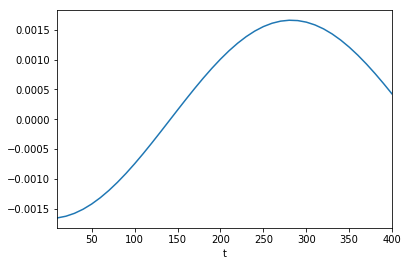

In [59]:
df_wave.set_index('t')['hTT_00'].plot()

In [ ]:
dump_list=list()
for t in t_list:
    x=df_x.loc[t].values.reshape((dim,num_part)).T
    p=df_p.loc[t].values.reshape((dim,num_part)).T
        
    P2=np.array([p[a].dot(p[a]) for a in p_idx])
    
    R2=np.array([[x[b]-x[a] for a in p_idx] for b in p_idx])
    mR2=np.linalg.norm(R2,axis=2)
    n2=np.array([[ np.zeros_like(R2[a,b]) if a==b else R2[a,b]/mR2[a,b] for a in p_idx] for b in p_idx])
    
    Phi=list()
    Htt_11=list()
    for xc,yc,zc in zip(X.flatten(),Y.flatten(),Z.flatten()):
        Phi.append(phi(xc,yc,zc,x,m,mR2,P2))
        Htt_11.append(hTT(xc,yc,zc,x,p,m,mR2,n2,P2,0,0))
    df_phi=pd.DataFrame({'x':X.flatten(),'y':Y.flatten(),'z':Z.flatten(),'phi':Phi,'hTT_00':Htt_11})

    z_val=df_phi['z'].abs().max()
    df_z=df_phi.query('z=='+str(z_val))
    Psi4=(1+0.125*df_z['phi'].values.reshape(nx,ny))**4
    dump_list.append({"psi4":Psi4,"t":t,'hTT_00':df_z['hTT_00'].values.reshape(nx,ny)})

In [8]:
def plot_dump(t):
#    fig = plt.figure(figsize=(10,5))
#    ax = fig.add_subplot(111, projection='3d')
#    ax.plot_wireframe(X[:,:,0], Y[:,:,0], np.log(dumps_list[t]['z']), rstride=1, cstride=1)
    plt.imshow(dump_list[t]['hTT_00'], extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)),
        cmap=cm.hot)
    plt.show()
d=interact(plot_dump,t=widgets.IntSlider(min=0,max=len(dump_list)-1,continuous_update=True))

In [6]:
grid_size=h5file['coordinates/x'].shape
xc=h5file['coordinates/x'][:,:,grid_size[2]/2]
yc=h5file['coordinates/y'][:,:,grid_size[2]/2]

r_indx=np.sqrt(xc**2+yc**2) < 25

dumps_len=len(h5file['0/fields'].keys())
metric=[h5file['0/fields/'+str(i)+'/metric_0_0'][:,:,grid_size[2]/2] for i in np.arange(dumps_len)]

def plot_metric_map(i):
    data=metric[i]
    data[r_indx]=1
    plt.imshow(data, extent=(np.amin(xc), np.amax(xc), np.amin(yc), np.amax(yc)),
            cmap=cm.hot, norm=LogNorm())
    plt.colorbar()
    plt.show()
    

In [37]:
d=interact(plot_metric_map,i=widgets.IntSlider(max=dumps_len-1))

In [15]:
def get_waves(h5file):
    l_modes=[2,3] 
    columns=["t"]
    name=["Q","O","CQ"]
    for l in l_modes:
        for p in ['R','I']:
            for m in np.arange(start=-l,stop=l+1):
                columns.append(p+'['+name[l-2]+'m='+str(m)+"]")
    l=3
    for p in ['R','I']:
        for m in np.arange(start=-l,stop=l+1):
            columns.append(p+'['+name[l-1]+'m='+str(m)+"]")
    return pd.DataFrame(h5file['0']['waves'][:],columns=columns)       
    
df_waves2=get_waves(h5file).set_index('t')

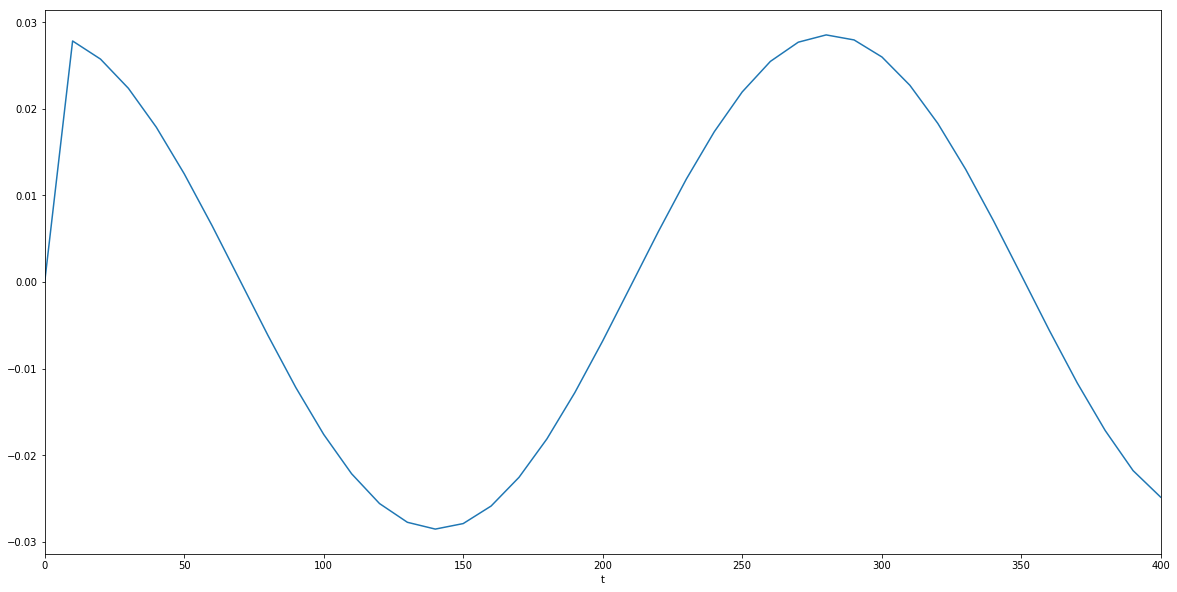

In [17]:
df_waves2['R[Qm=2]'].plot(figsize=(20,10))

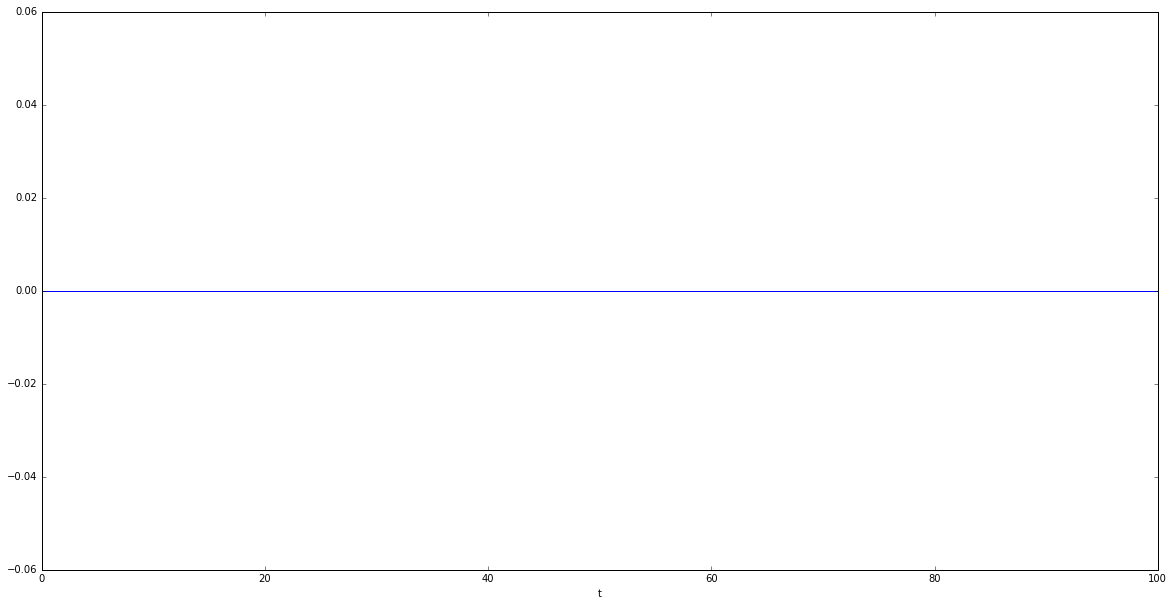

In [24]:
df_waves['R[Qm=-1]'].plot(figsize=(20,10))

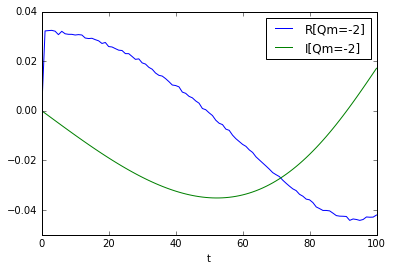

In [25]:
df_waves.iloc[:,(0,5)].plot()

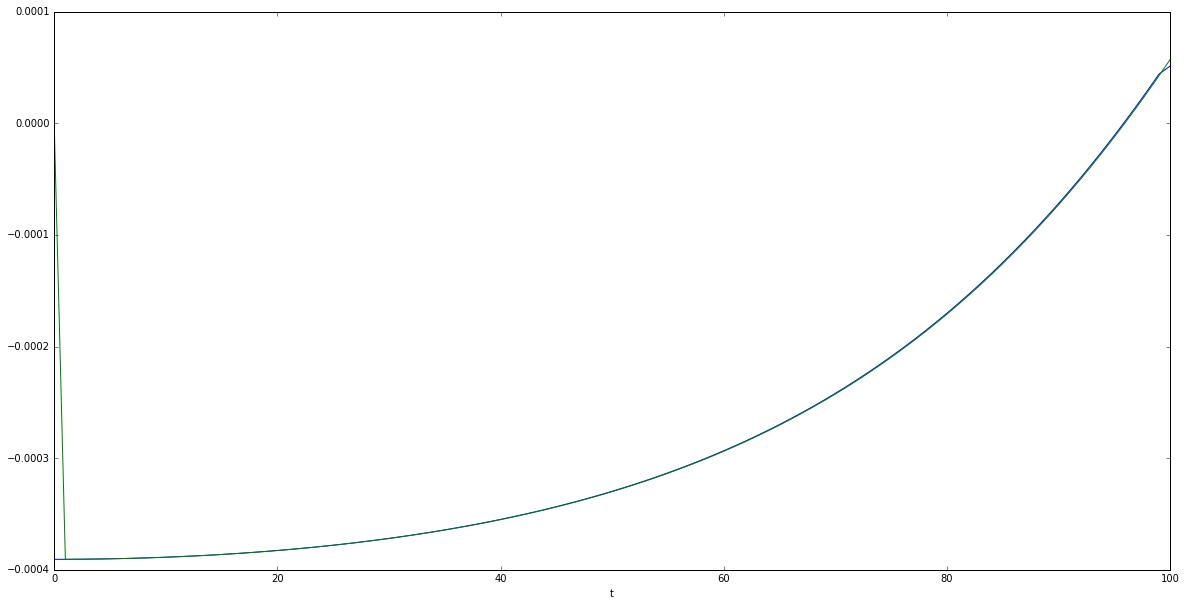

In [26]:
ax=pd.Series(np.gradient(df_dxdt['x1'].values,df_dxdt.index.values),index=df_dxdt.index).plot(figsize=(20,10))
(df_ddxdt2['x1']).plot(figsize=(20,10),ax=ax)


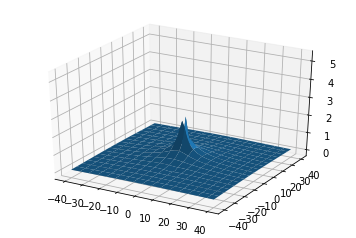

In [8]:
grid_size=h5file['coordinates/x'].shape
xc=h5file['coordinates/x'][:,:,grid_size[2]/2]
yc=h5file['coordinates/y'][:,:,grid_size[2]/2]
metric=h5file['0/fields/40/metric_0_0'][:,:,grid_size[2]/2]

fig_2d= plt.figure(1)
ax=fig_2d.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(xc, yc, np.log10(metric), rstride=4, cstride=4, linewidth=0)

In [56]:
df_p

,x1,x2,y1,y2,z1,z2
t,,,,,,
0.0,0.000000,0.000000,-0.020125,0.020125,0,0
10.0,-0.002245,0.002245,-0.019999,0.019999,0,0
20.0,-0.004463,0.004463,-0.019624,0.019624,0,0
30.0,-0.006624,0.006624,-0.019003,0.019003,0,0
40.0,-0.008703,0.008703,-0.018145,0.018145,0,0
50.0,-0.010673,0.010673,-0.017061,0.017061,0,0
60.0,-0.012510,0.012510,-0.015764,0.015764,0,0
70.0,-0.014191,0.014191,-0.014270,0.014270,0,0
80.0,-0.015694,0.015694,-0.012597,0.012597,0,0


In [55]:
df_x

,x1,x2,y1,y2,z1,z2
t,,,,,,
0.0,2.000000,-18.000000,0.000000,0.000000,0,0
10.0,1.987513,-17.887617,-0.223141,2.008271,0,0
20.0,1.950208,-17.551872,-0.443496,3.991465,0,0
30.0,1.888551,-16.996957,-0.658313,5.924817,0,0
40.0,1.803311,-16.229801,-0.864910,7.784186,0,0
50.0,1.695554,-15.259983,-1.060706,9.546355,0,0
60.0,1.566624,-14.099615,-1.243258,11.189318,0,0
70.0,1.418132,-12.763185,-1.410284,12.692560,0,0
80.0,1.251931,-11.267381,-1.559701,14.037310,0,0


In [49]:
df_x.iloc[10].values.reshape((3,2)).T[0]

array([ 0.87490237, -1.79848409,  0.        ])

In [46]:
df_x.iloc[10]

x1     0.874902
x2    -7.874121
y1    -1.798484
y2    16.186357
z1     0.000000
z2     0.000000
Name: 100.0, dtype: float64